In [1]:
import os   # for path operations
import datetime

import tensorflow as tf
from tensorflow.python.client import device_lib

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15594264716513317931
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9202108990
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9708454074868367256
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [21]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1,nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', 
                   input_shape=(window_size,nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs,activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [39]:
def make_timeseries_instances(timeseries,window_size,nb_inputs):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {}".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start+window_size,:nb_inputs] for start in range(0,timeseries.shape[0]-window_size)]))
    #y = timeseries[window_size:,nb_inputs:]
    y = timeseries[window_size:,-9]
    return X,y

In [44]:
def evalute_timeseries(timeseries, window_size, filter_length, nb_filter ):
    #timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T
    nb_samples, nb_series = timeseries.shape
    nb_inputs = nb_series - 9 #only 10 inputs
    #nb_outputs = nb_series - 10 #only 9 outputs
    nb_outputs=1
  
    model= make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_inputs,
                        nb_outputs=nb_outputs,nb_filter=nb_filter)
    model.summary()
  
    X,y = make_timeseries_instances(timeseries, window_size,nb_inputs=nb_inputs)
  
    test_size = int(0.3  * nb_samples)
    X_train, X_test, y_train, y_test = X[:-test_size,:], X[-test_size:,:], y[:-test_size], y[-test_size:]
  
    model.fit(X_train,y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=2)
  
    preds=model.predict(X_test)
    targets = y_test
    print(preds.shape)
    print(targets.shape)
    plt.plot(preds)
    plt.plot(targets)

# Load Data

In [6]:
lock_meas = '..\\DATA\\RAW\\Measure_02'
file_list = os.listdir(lock_meas)
nb_meas = len(file_list)/4
print("Number of Measurements: %0.f" % nb_meas)

Number of Measurements: 6


In [7]:
meas_list = []
for FILE_NAME in file_list:
    meas_list.append(FILE_NAME[0:22])
meas_list = list(set(meas_list))

In [8]:
# Load in one favourite measurement block
meas_id = 5

if meas_id>(nb_meas-1):
    print('Error: Out of range. Meas_id set to default 0')
    meas = 0
meas_date = str(meas_list[meas_id])

imu_data = pd.read_csv(lock_meas + '\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

mocap_data = pd.read_csv(lock_meas + '\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])


In [9]:
imu_data.head(5)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2
0,182339.3406,0.000,-0.052,1.025,-0.846,-0.101,-0.148,0.000,0.000,0.000
1,182339.3506,-0.000,-0.053,1.025,-0.987,0.302,-0.134,0.000,0.000,0.000
2,182339.3605,0.000,-0.053,1.025,-0.886,0.262,-0.107,-0.345,-0.282,0.058
3,182339.3695,0.001,-0.053,1.025,-0.806,0.101,0.107,-0.345,-0.282,0.064
4,182339.3785,0.000,-0.052,1.026,-0.987,0.161,-0.148,-0.345,-0.282,0.058


In [10]:
mocap_data.head(5)

,time,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182339.3406,0.711,0.212,-0.718,1.0,6.381,0.012,-0.056,0.005,0.998
1,182339.3506,0.711,0.212,-0.718,1.0,6.392,0.012,-0.056,0.005,0.998
2,182339.3605,0.711,0.212,-0.718,1.0,6.397,0.013,-0.056,0.005,0.998
3,182339.3695,0.711,0.212,-0.718,1.0,6.388,0.012,-0.056,0.005,0.998
4,182339.3785,0.711,0.212,-0.718,1.0,6.404,0.012,-0.056,0.005,0.998


In [11]:
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')
len(data)

8671

In [12]:
data.head()

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,x,y,z,tracked,beta,Qx,Qy,Qz,Qw
0,182339.3406,0.000,-0.052,1.025,-0.846,-0.101,-0.148,0.000,0.000,0.000,0.711,0.212,-0.718,1.0,6.381,0.012,-0.056,0.005,0.998
1,182339.3506,-0.000,-0.053,1.025,-0.987,0.302,-0.134,0.000,0.000,0.000,0.711,0.212,-0.718,1.0,6.392,0.012,-0.056,0.005,0.998
2,182339.3605,0.000,-0.053,1.025,-0.886,0.262,-0.107,-0.345,-0.282,0.058,0.711,0.212,-0.718,1.0,6.397,0.013,-0.056,0.005,0.998
3,182339.3695,0.001,-0.053,1.025,-0.806,0.101,0.107,-0.345,-0.282,0.064,0.711,0.212,-0.718,1.0,6.388,0.012,-0.056,0.005,0.998
4,182339.3785,0.000,-0.052,1.026,-0.987,0.161,-0.148,-0.345,-0.282,0.058,0.711,0.212,-0.718,1.0,6.404,0.012,-0.056,0.005,0.998


In [13]:
#1D convolution
window_size = 20
filter_length = 5
nb_filter = 4

#Train config
epochs = 50
batch_size = 16
validation_split = 0.2

In [29]:
timeData=np.array(data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 16, 4)             204       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 8, 4)              0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 2, 4)              0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________
Train on 484

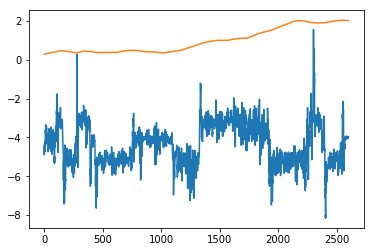

In [45]:
evalute_timeseries(timeData,window_size,filter_length,nb_filter)